## Analysis of EVI Negative Trend Breaks with XGBoost - Method 1

Peter R., 2023-07-31

#### File and folder path settings
There are several way to carry our Extreme Gradient Boosting. You could use R or Python.  There are several R packages to do so such as "dismo" and "xgboosting". In Pythin there are several ways as well. You can do XGB with the sklearn framework and within this framework you can use "xgboost"  train(), XGBClassifier(), etc.  Here I use train().

The Enhanced Vegatation Index (EVI) trend breaks used below are the outputs of BFast modelling carried out with R (see R folder).

In [66]:
# Import the os module
import os

# Get the current working directory
cwd = os.getcwd()

print(cwd)

C:\Users\Peter R\github\forc_trends\models\xgboost


#### Load and explore the data

In [4]:
# Set up libraries
from numpy import loadtxt

# load data
evi_array1 = loadtxt(r'.\data\forest_drivers1.csv', delimiter=',', skiprows=1)
#evi_array2 = loadtxt(r'.\data\forest_drivers_unk1.csv', delimiter=',')

numSamples, numFeatures = evi_array1.data.shape

print(numSamples)
print(numFeatures)


174
9


In [5]:
# split data into X and y
X1 = evi_array1[:,0:8]
Y1 = evi_array1[:,8]

X1[:5,:8]

# New data
#X2 = evi2[:,0:7]
#Y1 = evi2[:,7]

array([[-765.  ,   56.42,   24.7 ,   74.8 ,    0.  ,  373.  ,  813.  ,
           4.4 ],
       [-432.  ,   34.42,   22.7 ,   76.7 ,    0.  ,  374.  ,  813.  ,
           4.4 ],
       [-614.  ,   53.18,   18.5 ,   78.8 ,    0.  ,  380.  , 1018.  ,
           5.06],
       [-276.  ,   72.76,   70.2 ,   29.5 ,    0.  ,  454.  ,  998.  ,
           4.22],
       [-291.  ,   88.82,   29.7 ,   30.7 ,    0.  ,  167.  ,  819.  ,
           6.9 ]])

([], [])

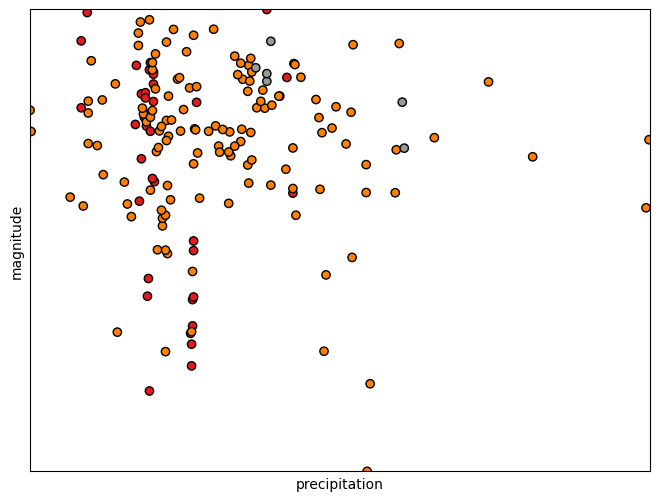

In [6]:
import matplotlib.pyplot as plt

# import some data to play with
X = evi_array1[:, [6, 0]]  # we only take the first two features.
y = Y1

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Set1, edgecolor="k")
plt.xlabel("precipitation")
plt.ylabel("magnitude")

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

#### Set up model

In [7]:
# using EVI breaks
from sklearn.model_selection import train_test_split

seed = 7
testsize1 = 0.2

# to help deal with unbalanced data use stratify=yes. But don't use here yet.
x_train, x_test, y_train, y_test = train_test_split(X1, Y1, test_size=testsize1, random_state=seed)



In [8]:
sum(y_train)/len(y_train) # values should be the same as below


0.7985611510791367

In [9]:

sum(y_test)/len(y_test) # Given that values are not the same, the data show imbalance

0.9142857142857143

#### Run model

In [63]:
import xgboost as xgb

# Model Method 1a: This is the baseline model using train(). This method needs DMatrix objects
col_names = ["magnitude","age","deciduous","conifers","protected","elevation","precipitation","temperature"]

train = xgb.DMatrix(x_train, label=y_train, feature_names=col_names)
test = xgb.DMatrix(x_test, label=y_test, feature_names=col_names)


# change parameters accordingly. Ideally, do a sensitivity test with GridSearch
param = {
    'max_depth': 4,
    'eta':0.3,
    'objective': 'multi:softmax',
    'num_class': 3
}

epochs = 10

# train() defaults to 'multisoftmax' when more than two classes are found in y_train.
model_m1a = xgb.train(param, train, epochs, num_boost_round=10)


In [75]:
# Model Method 1b: This model includes weights to help with imbalanced data
from sklearn.utils import class_weight

weights1  = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

print(y_train[:3])
print(weights1[:3])

train2 = xgb.DMatrix(x_train, label=y_train, weight=weights1, feature_names=col_names) # This is a DMatrix object

# train() defaults to 'multisoftmax' when more than two classes are found in y_train.
model_m1b = xgb.train(param, train2, epochs, num_boost_round=50, evals=[(train, "train"), (test, "validation")], early_stopping_rounds=20) # 

[1. 0. 1.]
[0.45874587 1.4040404  0.45874587]
[0]	train-mlogloss:0.81317	validation-mlogloss:0.83964
[1]	train-mlogloss:0.63945	validation-mlogloss:0.68660
[2]	train-mlogloss:0.51673	validation-mlogloss:0.57753
[3]	train-mlogloss:0.42821	validation-mlogloss:0.52927
[4]	train-mlogloss:0.37263	validation-mlogloss:0.48441
[5]	train-mlogloss:0.32203	validation-mlogloss:0.44958
[6]	train-mlogloss:0.28264	validation-mlogloss:0.41734
[7]	train-mlogloss:0.24739	validation-mlogloss:0.39801
[8]	train-mlogloss:0.21471	validation-mlogloss:0.38737
[9]	train-mlogloss:0.18473	validation-mlogloss:0.36567


In [72]:
model_m1b.best_ntree_limit

10

In [80]:
model_m1b.predict(test, ntree_limit=model_m1b.best_ntree_limit)

array([1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1.,
       1.], dtype=float32)

##### Test the model with brand new data

In [12]:
# Not run
# This is the brand new data to test how well the model does.
# in this data set I don't have a label
#testNewData = xgb.DMatrix(X2)
#print(testNewData)

#### Fine tunning parameters
Fine tune parameters to find a better model (potentially). Note: This currently does not work becasue of the low number of fire and insect drivers in my test data

In [13]:
# Fine tune parameters using GridSearchCV. 
# This won't work becasue of the limitation of the data. ALso, it seems it can be run with train()

# Model 3: GridSearch Model
param_grid1 = {
'max_depth' : [3,4,5],
'learning_rate': [0.1, 0.01, 0.05],
'gamma': [0, 0.25, 1.0],
'reg_lambda': [0, 1.0, 10.0],
}


#### Predictions
Now let's se how well the mdoels can predict

In [40]:
predictions_m1a = model_m1a.predict(test)
print(predictions_m1a)

[1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1.
 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1.]


In [41]:
predictions_m1b = model_m1b.predict(test)
print(predictions_m1b)

[1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1.
 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1.]


In [178]:
# Prediction using new data (not initial train or test data)
#predictionsNew = model.predict(testNewData)

#### Model accuracy
Let's measure the accuracy of the models

In [19]:
from sklearn.metrics import accuracy_score 

print('model m1a:', accuracy_score(y_test, predictions_m1a))
print('model m1b:', accuracy_score(y_test, predictions_m1b))
# It seems that accuracy is the same


model m1a: 0.9142857142857143
model m1b: 0.9142857142857143


In [22]:
# Cross-Validation model - Does not work yet with DMatrix objects.  
#from sklearn.model_selection import KFold
#from sklearn.model_selection import cross_val_score

#kfold = KFold(n_splits=10) #(... , random_state=seed, shuffle=True)
#results = cross_val_score(model_m1a, X1, Y1, cv=kfold)
#print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

#### Model plots

{'magnitude': 0.7902762293815613, 'age': 0.8968190550804138, 'deciduous': 0.7901024222373962, 'conifers': 2.1240828037261963, 'elevation': 1.7510524988174438, 'precipitation': 2.3464765548706055, 'temperature': 1.7616039514541626}


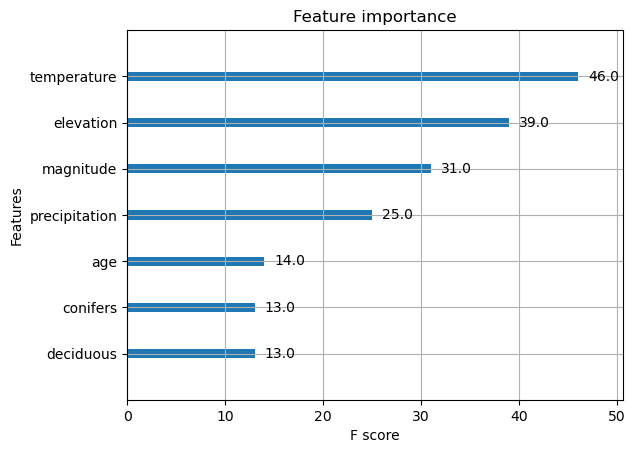

In [49]:
# Model m1a
# feature importance
print(model_m1a.get_score(importance_type='gain'))

# plot
xgb.plot_importance(model_m1a, max_num_features=10)
plt.show()

Weight
{'magnitude': 22.0, 'age': 8.0, 'deciduous': 14.0, 'conifers': 8.0, 'elevation': 47.0, 'precipitation': 20.0, 'temperature': 53.0}
Cover
{'magnitude': 16.903627395629883, 'age': 7.7323760986328125, 'deciduous': 16.028894424438477, 'conifers': 20.704708099365234, 'elevation': 24.906551361083984, 'precipitation': 20.171430587768555, 'temperature': 18.393878936767578}
Gain
{'magnitude': 1.1051844358444214, 'age': 0.43424034118652344, 'deciduous': 0.9394307732582092, 'conifers': 2.7889046669006348, 'elevation': 5.488593101501465, 'precipitation': 2.5869030952453613, 'temperature': 2.2757599353790283}


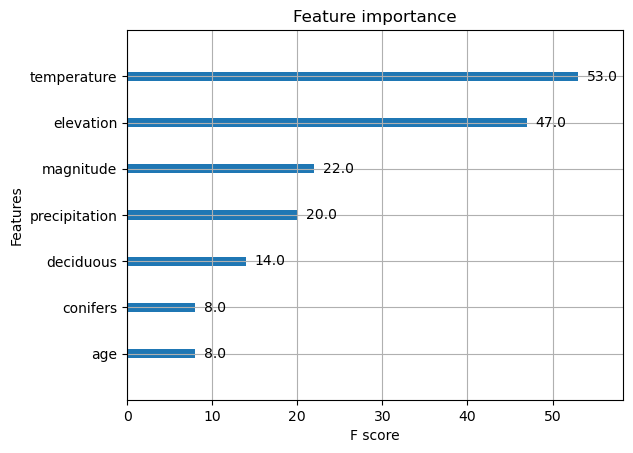

In [52]:
# Model m1b (model with weights)
# feature importance

print("Weight")
print(model_m1b.get_score(importance_type='weight'))

print("Cover")
print(model_m1b.get_score(importance_type='cover'))

print("Gain")
print(model_m1b.get_score(importance_type='gain'))


# plot
xgb.plot_importance(model_m1b, max_num_features=10)
plt.show()

In [53]:
print("Total Cover")
print(model_m1b.get_score(importance_type='total_cover'))

print("Total Gain")
print(model_m1b.get_score(importance_type='total_gain'))

Total Cover
{'magnitude': 371.8797912597656, 'age': 61.8590087890625, 'deciduous': 224.40452575683594, 'conifers': 165.63766479492188, 'elevation': 1170.60791015625, 'precipitation': 403.4286193847656, 'temperature': 974.8755493164062}
Total Gain
{'magnitude': 24.314058303833008, 'age': 3.4739227294921875, 'deciduous': 13.152030944824219, 'conifers': 22.311237335205078, 'elevation': 257.9638671875, 'precipitation': 51.73806381225586, 'temperature': 120.61528015136719}


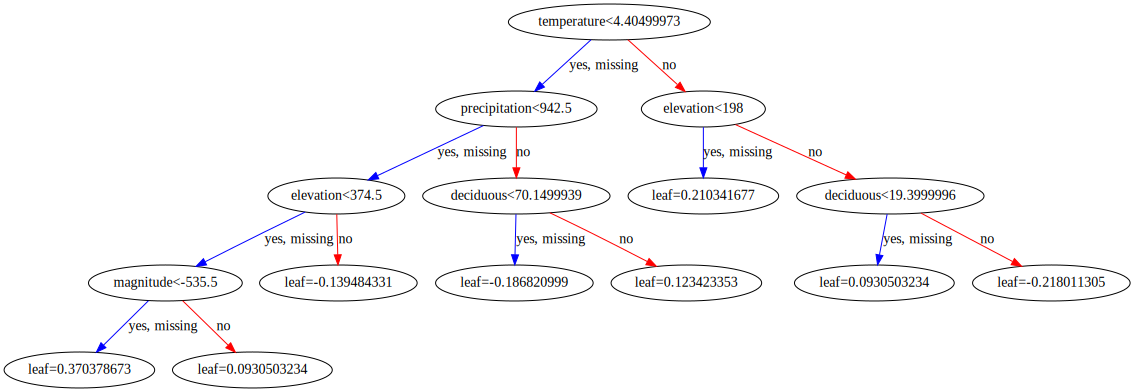

In [65]:
# Plot tree. (Note: I havd to install graphviz from the conda cmd line)
import graphviz

#fig, ax = plt.subplots(figsize=(8, 6)) #plt.figure(2, figsize=(8, 6))
#xgb.plot_tree(model, num_trees=4)

xgb.to_graphviz(model_m1b, size=6, num_trees = 0)


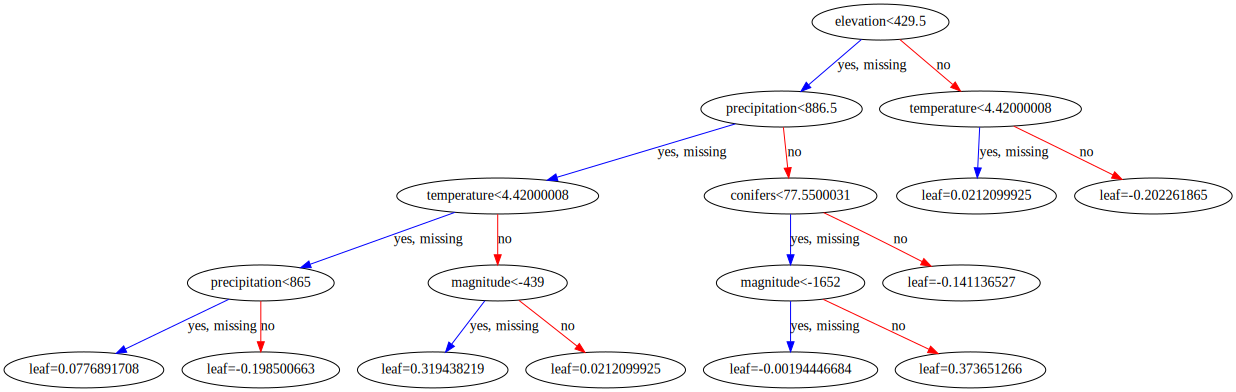

In [55]:

xgb.to_graphviz(model_m1b, size=6, num_trees = 1)


In [60]:
0.0212099925-0.202261865-0.141136527-0.00194446684+0.373651266+0.0212099925+0.319438219+0.0776891708-0.198500663

0.26935511896

In [67]:
booster1 = model_m1b.get_booster()

# Dump the model and load the dump
model_json_path = 'C:/Users/Peter R/github/forc_trends/models/xgboost.json'
booster1.dump_model(model_json_path, dump_format='json')
#with open(model_json_path, 'r') as f:
#    model_dict = json.loads(f.read())

AttributeError: 'Booster' object has no attribute 'get_booster'

#### References

Tutorials:

https://www.youtube.com/watch?v=OQKQHNCVf5k

https://www.youtube.com/watch?v=GrJP9FLV3FE&t=2167s

https://datascience.stackexchange.com/questions/16342/unbalanced-multiclass-data-with-xgboost
